<h1 align='center'> Vector Representations of Movie Plots </h1>

In this notebook we take plot summaries and create the vector representations using the algorithm Doc2Vec. This is then used to analyze movie similarities across different dimensions.

<hr>


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
from gensim import models, corpora
import multiprocessing
import urllib2
from gensim import models
import pickle
import re
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA

In [2]:
# TODO: Set this appropriately
dropbox_dir = "C:\\Users\\sooraj.raveendra\\Dropbox\\moviemeta\\"

## Functions for Dimensionality Reduction an Visualization

In [3]:
def apply_mds(vectors):
    mds = MDS(n_components=2, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = mds[:, 0]
    df['y'] = mds[:, 1]
    return df

def apply_tsne(vectors, rate=1000):
    tsne = TSNE(learning_rate=rate, init='pca', perplexity=10, early_exaggeration=20.0, random_state=1).fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = tsne[:, 0]
    df['y'] = tsne[:, 1]
    return df

def apply_pca(vectors):
    pca = PCA().fit_transform(vectors)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = pca[:, 0]
    df['y'] = pca[:, 1]
    return df

def apply_isomap(vectors, neighbours=10):
    map_2d = Isomap(neighbours, 2, eigen_solver='auto').fit_transform(vectors)    
    df = pd.DataFrame(map_2d, columns=['x', 'y'])
    return df

In [4]:
from matplotlib import pyplot
from matplotlib  import cm
import matplotlib.colors as mpcol

'''
 Matplotlib scatterplots with colour-coded categories and text annotations
'''
def plot_2d_scatter(df, labels, categories, title, figsize=(10,10)):
    
    if(categories is not None):
        df['cat'] = categories
        groups = df.groupby('cat')
        fig, ax = pyplot.subplots(figsize=figsize)
        #plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
        colors = pd.tools.plotting._get_standard_colors(len(groups), colormap=cm.jet)
        ax.set_color_cycle(colors)
        for name, group in groups:
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
        ax.legend(numpoints=1, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.figure(figsize=(10, 10))
        a = df.plot(kind='scatter', x='x', y='y', marker='o')
        a.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    
    if(labels is not None):
        for label, x, y in zip(labels, df.x, df.y):
            pyplot.annotate(label, xy=(x, y))

    plt.title(title)
    plt.show()
    

In [99]:
sns.xkcd_palette(['purple', 'green', 'blue', 'pink', 'brown', 'red']).as_hex()[:4]

[u'#7e1e9c', u'#15b01a', u'#0343df', u'#ff81c0']


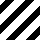
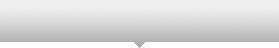
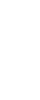
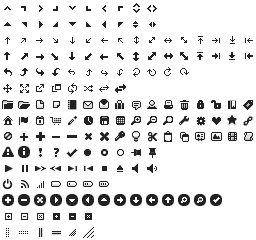
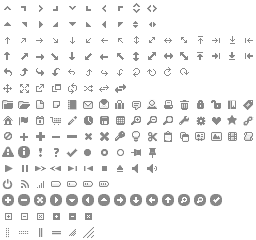
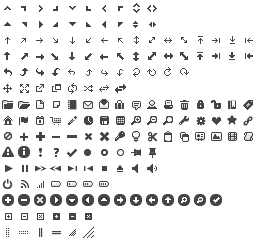
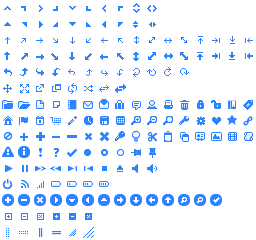
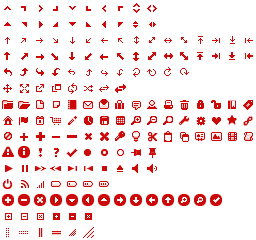
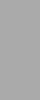
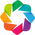
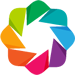
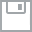
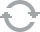
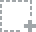
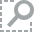
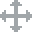
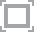
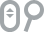

In [168]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
import seaborn as sns
output_notebook()

'''
Scatter plot using bokeh library
Adapted from: http://aylien.com/web-summit-2015-tweets-part1

@param df - DataFrame with columns x and y
@param labels - list of labels for each point
@param categories - list of categories for each point (category assignments)
@param title - title for the plot
@param categories_to_show - list of categories to use for colour-coding. 
                            All other categories will be labelled "Other"
@param point_label - common prefix string for the tooltip label for all points
@param static_label - whether to annotate the points statically (not on mouseover)

'''
def plot_2d_scatter_bokeh(df, labels, categories, title, categories_to_show = None, point_label="movie", static_label=False):
    bplot = bp.figure(plot_width=800, plot_height=800, title=title,
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=2, background_fill="#E8DDCB")

    color_assignment = []

    if(categories is not None):
        if(categories_to_show is None):
            categories_to_show = list(set(categories))

        #pal = sns.color_palette('cubehelix', len(categories_to_show))
        color_list = sns.xkcd_palette(['purple', 'green', 'blue', 'pink', 'brown', 'red', 'orange', 'yellow', 
                                       'rose', 'pea green', 'mustard', 'fuchsia', 'beige', 
                                       'cloudy blue', 'candy pink', 'golden rod', 'salmon', 'light brown', 
                                       'aquamarine', 'mauve', 'lilac']).as_hex()[:len(categories_to_show)]

        for i in range(0, len(categories)):
            try:
                cat_index = categories_to_show.index(categories[i])
            except:
                # Assuming the default category named "Other"
                cat_index = categories_to_show.index("Other")

            color_assignment.append((color_list[cat_index]))
    else:
        categories = labels
        color_assignment = ["#771122"] * len(labels)
        
    bplot.scatter(x = df.x, y = df.y,
                        color = color_assignment,
                        source = bp.ColumnDataSource({"label": labels,
                                                      "category": categories}))
    if(static_label):
        bplot.text(x = df.x, y = df.y,
                    text=labels, text_color="#333333",
                    text_align="right", text_font_size="8pt")
    
    hover = bplot.select(dict(type = HoverTool))
    if(static_label):
        hover.tooltips = {"%s" % point_label: "@label"}
    else:
        hover.tooltips = {"%s" % point_label: "@label - @category"}
    
    show(bplot)
    return bplot

## Wikipedia Plots
<hr>

### doc2vec processing

In [26]:
# Load the data saved from processing.ipynb
wiki_meta_df = pd.read_csv(dropbox_dir + 'wiki_meta_df.csv')

with open(dropbox_dir +'wiki_plots_d2v_new.pickle', 'rb') as f:
    wiki_plots = np.load(f)


In [27]:
def create_tagged_doc_list(plots, labels=None):
    tagged_docs = []
    for i, plot in enumerate(plots):
        plot_words = []
        for tagged_sent in plot:
            plot_words += tagged_sent.words
        
        if(labels is None):
            tag = plot[0].tags
        else:
            tag = [labels[i]]
            
        tagged_docs.append(models.doc2vec.TaggedDocument(words = plot_words, tags = tag))

    return tagged_docs

plots_tagged_with_titles = create_tagged_doc_list(wiki_plots) 

In [28]:
print "number of unique titles: ", len(pd.DataFrame(plots_tagged_with_titles, columns=['plot', 'title']).title.apply(lambda x: x[0]).unique())

# Filter out those with very small plot summaries
plots_tagged_with_titles = [p for p in plots_tagged_with_titles if len(p.words) > 200]
print "after removing small plots, we have %d titles" % len(plots_tagged_with_titles)

number of unique titles:  17810
after removing small plots, we have 7199 titles


In [29]:
%%time
cores = multiprocessing.cpu_count()
d2v_wiki = models.Doc2Vec(dm=1, size=64, window=10, negative=5, min_count=10, workers=cores)
#d2v_wiki = models.Doc2Vec(dbow_words=1, size=100)
#d2v_wiki = models.Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#d2v_wiki = models.Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v_wiki.build_vocab(plots_tagged_with_titles)
d2v_wiki.train(plots_tagged_with_titles)

Wall time: 5.5 s


### Order the labels to match the vectors

In [183]:
# Convert titles to the same format as plot tags
wiki_meta_df.title = wiki_meta_df.apply(lambda row: "%s (%d)" % (row.title, row.year), axis=1)

# Convert country names to standard form
def clean_country_name(c):
    if(c == 'Cinema_of_the_United_States'):
        return 'United States'
    elif(c == 'United_States'):
        return 'United States'
    elif(c == 'Cinema_of_Thailand'):
        return 'Thailand'
    elif(c == 'United_Kingdom'):
        return 'United Kingdom'
    elif(c == 'Hong_Kong'):
        return 'Hong Kong'
    elif(c == 'South_Korea'):
        return 'South Korea'
    elif(c == 'Cinema_of_Japan'):
        return 'Japan'
    elif(c == 'Cinema_of_India'):
        return 'India'
    elif(c == 'USA'):
        return 'United States'
    elif(c == 'UK'):
        return 'United Kingdom'
    elif(c == 'South_Africa'):
        return 'South Africa'
    else:
        return c

In [47]:
%%time

from collections import Counter

wiki_titles = list(set([s.tags[0] for s in plots_tagged_with_titles]))
wiki_vectors = [d2v_wiki.docvecs[t] for t in wiki_titles]
wiki_titles = [unicode(s, 'utf-8') for s in wiki_titles]

wiki_meta_df.countries = wiki_meta_df.countries.fillna("Unknown")
wiki_meta_df.countries = wiki_meta_df.countries.apply(clean_country_name)

top_countries = Counter(c for c in wiki_meta_df.countries).most_common(20)
top_countries = [c[0] for c in top_countries]

# Contries corresponding to the movies in the dataframe, in the same order
wiki_countries_all = []
# Only the countries we want to show in the plots, with other countries marked as "Others"
wiki_countries_show = []
wiki_years = []

for t in wiki_titles:
    country = list(wiki_meta_df[wiki_meta_df.title == t.encode('utf8')].countries.values)[0]
    wiki_countries_all.append(country)
    if country in top_countries:
        wiki_countries_show.append(country)
    else:
        wiki_countries_show.append('Other') 

    year =  list(wiki_meta_df[wiki_meta_df.title == t.encode('utf8')].year.values)[0]
    wiki_years.append(year)


Wall time: 21.5 s


In [66]:
## Take a smaller subset of the data to save time during testing

#import random

#sample = random.sample(zip(wiki_vectors, wiki_titles, wiki_countries_all, wiki_countries_show, wiki_years), 1500)
#wiki_vectors, wiki_titles, wiki_countries_all, wiki_countries_show, wiki_years = zip(*sample)

### Project the vectors down to 2-D and plot them

In [140]:
wiki_d2v_pca = apply_pca(wiki_vectors)

#plot_2d_scatter(wiki_d2v_pca, wiki_titles, wiki_countries, "Wiki Plots - PCA")
plot_titles_pca = plot_2d_scatter_bokeh(wiki_d2v_pca, wiki_titles, wiki_countries_show, "Movie Plot Similarity (PCA)")


In [106]:
%%time
wiki_d2v_tsne = apply_tsne(wiki_vectors, rate=500)
#plot_2d_scatter(wiki_d2v_tsne, None, wiki_countries, "Wiki Plots - tSNE")
plot_titles_tsne = plot_2d_scatter_bokeh(wiki_d2v_tsne, wiki_titles, wiki_countries_show, "Movie Plot Similarity (tSNE)")

Wall time: 11min 54s


In [107]:
from bokeh.resources import CDN
from bokeh.embed import file_html
html = file_html(plot_titles_tsne, CDN, "Movie Plot Similarity - tSNE")

with open('doc2vec_movie_similarity.html', 'a') as f:
    f.write(html)

In [117]:
d2v_wiki.docvecs.most_similar('Amélie (2001)')

[('Out of Step (2002)', 0.9784718155860901), ('Love & Basketball (2000)', 0.9767455458641052), ('Avalon (2001)', 0.9708749651908875), ('Red Planet (2000)', 0.9670013189315796), ('Highlander: Endgame (2000)', 0.9651334881782532), ('The Man Who Cried (2000)', 0.9637507796287537), ('Time and Tide (2000)', 0.962949275970459), ('Exit Wounds (2001)', 0.9623919129371643), ("Help! I'm a Fish (2000)", 0.9612784385681152), ('Cabin by the Lake (2000)', 0.9612537026405334)]


## Country similarities

We try to get a plot of similar countries by taking the averages (centroids) of the document vectors for the corresponding plots.

In [141]:
country_vec_df = pd.DataFrame({'country':wiki_countries_all, 'plot_vector':wiki_vectors})

In [145]:
# Select the countries with significant number of movies
movie_counts = country_vec_df.groupby('country').apply(len)
countries_to_show = list(movie_counts[movie_counts > 30].index)
countries_to_show.remove('Unknown')    

In [146]:
def calculate_centroid(row):
    if(row.country.values[0] in countries_to_show):
        return np.mean(row.plot_vector)
    else:
        return None

country_centroids = country_vec_df.groupby('country').apply(calculate_centroid)
country_centroids = country_centroids.dropna()


In [169]:
vectors_2d = apply_tsne(list(country_centroids))
#plot_2d_scatter(vectors_2d, country_centroids.index, None, "Movie plot similarity across countries")
plot_2d_scatter_bokeh(vectors_2d, country_centroids.index, None, "Country similarities - Vector averaging", static_label=True)

# doc2vec with country tags

Usually we get better results by passing the categories as tags to the doc2vec algorithm than doing vector averaging. In this section, we train a doc2vec model with countries as labels.

In [187]:
%%time

wiki_meta_df.countries = wiki_meta_df.countries.fillna("Unknown")
country_tags = [clean_country_name(c) for c in wiki_meta_df.countries]
plots_tagged_with_countries = create_tagged_doc_list(wiki_plots, country_tags) 

cores = multiprocessing.cpu_count()
d2v_countries = models.Doc2Vec(dm=1, size=64, window=10, negative=5, min_count=5, workers=cores)
d2v_countries.build_vocab(plots_tagged_with_countries)
d2v_countries.train(plots_tagged_with_countries)

Wall time: 8.21 s


In [188]:
%%time

country_tags = list(set([s.tags[0] for s in plots_tagged_with_countries]))
country_vectors = [d2v_countries.docvecs[t] for t in country_tags]

# Pick the countries with the highest number of plots
top_countries = Counter([p.tags[0] for p in plots_tagged_with_countries]).most_common(40)
top_countries = [c[0] for c in top_countries if c[0] != 'Unknown']

countries_d2v_isomap = apply_isomap(country_vectors)
#plot_2d_scatter(wiki_d2v_tsne, None, wiki_countries, "Wiki Plots - tSNE")
top_vectors_idx = [country_tags.index(t) for t in top_countries]
plot_countries = plot_2d_scatter_bokeh(countries_d2v_isomap.loc[top_vectors_idx], 
                                       top_countries, None, 
                                       "Country similarities based on Wikipedia plots", 
                                       static_label=True, point_label="Country")

Wall time: 806 ms


We can now look at the similarities of country vectors

In [189]:
d2v_countries.docvecs.most_similar('Germany')

[('France, Germany', 0.9328152537345886),
 ('France, Italy', 0.9295707941055298),
 ('Greece', 0.9244847297668457),
 ('Belgium', 0.9186895489692688),
 ('Argentina, France, Spain', 0.917473554611206),
 ('Austria', 0.9148951172828674),
 ('Spain, United States', 0.9144474267959595),
 ('Belgium, Canada, China, United States', 0.9127089381217957),
 ('Spain', 0.9123870134353638),
 ('Czech Republic', 0.9114916920661926)]

In [190]:
d2v_countries.docvecs.most_similar('South Korea')

[('Hong Kong, South Korea', 0.7823368906974792),
 ('Taiwan', 0.7560669779777527),
 ('Canada, Germany, United Kingdom', 0.7542712688446045),
 ('* Thailand\r\n* United States', 0.7450735569000244),
 ('Serbia', 0.744551420211792),
 ('Afghanistan, Iran, Ireland, Japan, Netherlands', 0.7434068322181702),
 ('Austria, Germany, United Kingdom', 0.7419103384017944),
 ('Japan, South_Korea', 0.7371189594268799),
 ('Japan, South Korea', 0.7352309823036194),
 ('Turkey', 0.7319692373275757)]

In [191]:
d2v_countries.docvecs.most_similar('India')

[('India, Pakistan', 0.8736413717269897),
 ('India, United_Kingdom', 0.8686272501945496),
 ('Bangladesh', 0.8684360980987549),
 ('Pakistan', 0.868398904800415),
 ('india', 0.8634400367736816),
 ('Indian\r\n.', 0.8607553243637085),
 ('India, United Kingdom', 0.8548479080200195),
 ('India, Malaysia', 0.8489930629730225),
 ('Nepal', 0.8440724611282349),
 ('Canada, India', 0.8424718379974365)]

In [194]:
d2v_countries.docvecs.most_similar('United States')

[('Australia, United_States', 0.951349675655365),
 ('Canada', 0.9430030584335327),
 ('Netherlands, United States', 0.9429203271865845),
 ('UK/Germany', 0.9422036409378052),
 ('*United Kingdom\r\n*France\r\n*United States', 0.9390611052513123),
 ('Canada, United Kingdom', 0.9345242381095886),
 ('United States of America', 0.9328289031982422),
 ('Canada, United Kingdom, United States', 0.9319167137145996),
 ('Australia, United States', 0.9266565442085266),
 ('Germany, United_Kingdom, United_States', 0.9256555438041687)]

In [195]:
d2v_countries.docvecs.most_similar('United Kingdom')

[('Australia', 0.9264044761657715),
 ('Australia, United Kingdom', 0.9088666439056396),
 ('Ireland', 0.8940458297729492),
 ('France, United Kingdom', 0.8910786509513855),
 ('Austria, Germany', 0.8897481560707092),
 ('Netherlands, United States', 0.8886050581932068),
 ('France, Germany, Italy, United Kingdom, United States', 0.8875476121902466),
 ('Spain, United States', 0.8875325918197632),
 ('Ireland, United Kingdom', 0.8865044116973877),
 ('Australia / France', 0.8861131072044373)]

In [198]:
from bokeh.resources import CDN
from bokeh.embed import file_html
html = file_html(plot_countries, CDN, "Country Similarity")

with open('doc2vec_county_similarity.html', 'a') as f:
    f.write(html)

In [197]:
#from bokeh.embed import components
#script, div = components(plot_countries)
#print script

## IMDB Plots

(Incomplete)

<hr>

In [201]:
%%time

# Load the data saved from processing.ipynb
#imdb_meta_df = pd.read_csv(dropbox_dir + 'imdb_meta_df_cleaned.csv')

with open(dropbox_dir +'imdb_plots.list', 'rb') as f:
    imdb_plots  = f.readlines()

imdb_plots = [eval(p) for p in imdb_plots]

Wall time: 202 ms


In [41]:
cores = multiprocessing.cpu_count()
#d2v = models.Doc2Vec(dm=1, dm_concat=1, size=50, window=10, negative=5, hs=0, min_count=2, workers=cores)
d2v = models.Doc2Vec(dbow_words=1, size=50)
#Doc2Vec(dm=0, size=100, negative=5, hs=0, min_count=2, workers=cores)
#Doc2Vec(dm=1, dm_mean=1, size=100, window=10, negative=5, hs=0, min_count=2, workers=cores)
all_sent = create_labelled_sent_list(plots)
long_plots_sent = create_labelled_sent_list(long_plots)
d2v.build_vocab(all_sent)
d2v.train(long_plots_sent)

521620

In [42]:

imdb_titles = list(set([s.tags[0] for s in long_plots_sent]))
imdb_vectors = [d2v.docvecs[t] for t in imdb_titles]

Wall time: 120 ms


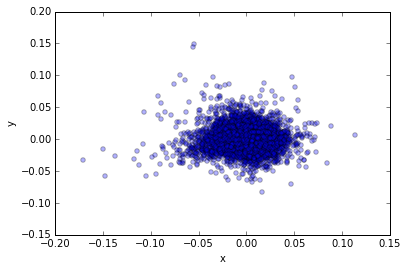

In [48]:
%%time
imdb_d2v_pca = apply_pca(imdb_vectors)
imdb_d2v_pca.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 6min 43s


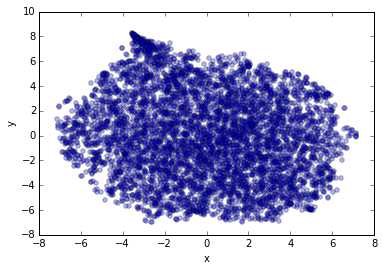

In [49]:
%%time
imdb_d2v_tsne = apply_tsne(imdb_vectors)
imdb_d2v_tsne.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 3min 12s


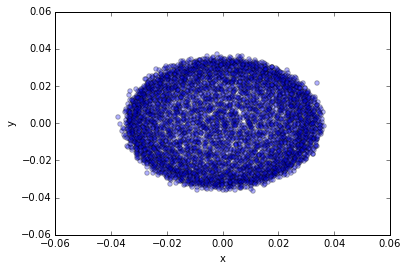

In [65]:
%%time
imdb_d2v_mds = apply_mds(imdb_vectors)
imdb_d2v_mds.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)

Wall time: 17 s


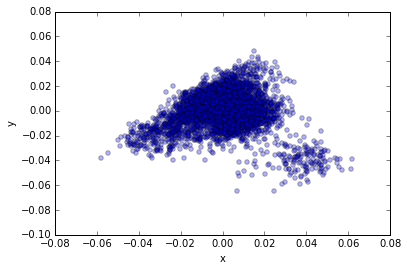

In [64]:
%%time
imdb_d2v_isomap = apply_isomap(imdb_vectors)
imdb_d2v_isomap.plot(kind='scatter', x='x', y='y', marker='o', alpha=0.3)